# Stock markets

In [1]:
# Install and import pandas_datareader
import pandas as pd
import numpy as np
# !pip install --upgrade pandas-datareader
from pandas_datareader import DataReader as pdr
# pd.options.display.float_format = '{:.2f}'.format
import plotly.graph_objects as go

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#### Data on equity portfolios from Ken French Data Library
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [2]:
# Fama-French 3-factors
# MKT-RF: market excess return over Tbills
# SMB: small minus big stock portfolio
# HML: high minus low book-to-market portfolio

# Monthly returns
mrets = pdr('F-F_Research_Data_Factors','famafrench', start=1900)[0]/100
# Clean-up missings
for c in mrets.columns:
    mrets[c] = np.where(mrets[c]==-99.99, np.nan, mrets[c])
mmkt = mrets['Mkt-RF'] + mrets['RF']

# Daily returns
drets = pdr('F-F_Research_Data_Factors_daily','famafrench', start=1900)[0]/100
drets.index = drets.index.to_period('D')
# Clean-up missings
for c in drets.columns:
    drets[c] = np.where(drets[c]==-99.99, np.nan, drets[c])
dmkt = drets['Mkt-RF'] + drets['RF']

# Annual returns
amkt = (1+mmkt).resample('Y').prod()-1
amkt.index = amkt.index.astype(str)
amkt = amkt.reset_index()
amkt.columns = ['year','ret']


## Annual returns

In [3]:
amkt

year       ret
0   1926  0.097061
1   1927  0.326068
2   1928  0.389290
3   1929 -0.148166
4   1930 -0.288155
..   ...       ...
94  2020  0.241081
95  2021  0.235791
96  2022 -0.201593
97  2023  0.266247
98  2024  0.286303

[99 rows x 2 columns]

In [4]:
# Plot annual returns
fig = go.Figure()
trace= go.Scatter(x=amkt.year, y=amkt.ret)
fig.add_trace(trace)
# some formatting
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Return",
    yaxis_tickformat=".0%"
)
fig.show()

In [5]:
# Plot the distribution of annual returns
fig = go.Figure()
trace= go.Histogram(x=amkt.ret, histnorm='percent',hovertemplate="<br>%{y:.2}% of years <br><extra></extra>")
fig.add_trace(trace)
# some formatting
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Annual Market Return",
    yaxis_title="Percent of Years",
    xaxis_tickformat=".0%"
)
fig.show()

In [6]:
amkt.describe()

ret
count  99.000000
mean    0.121328
std     0.198791
min    -0.440263
25%     0.000502
50%     0.154200
75%     0.269591
max     0.573598

In [7]:
# Summary statistics
print(f'Mean(annual return):\t {amkt.ret.mean(): ,.4f}')
print(f'SD(annual return):\t {amkt.ret.std(): ,.4f}')
print(f'Skew(annual return):\t {amkt.ret.skew(): ,.4f}')
print(f'Kurt(annual return):\t {amkt.ret.kurt(): ,.4f}')  # excess kurtosis

Mean(annual return):	  0.1213
SD(annual return):	  0.1988
Skew(annual return):	 -0.4741
Kurt(annual return):	  0.0586


In [9]:
# Plot compound return
compound = (1+amkt.ret).cumprod()
trace = go.Scatter(
    x=amkt.year,
    y=compound,
        hovertemplate="%{x}<br>$%{y:.2f}<extra></extra>",
    name="",
    )
fig = go.Figure(trace)
fig.update_layout(
    xaxis_title="",
    yaxis_title="Accumulation from $1",
    yaxis_tickformat=",.0f",
    width=1000,
    height=460,
    legend=dict(
        yanchor="top", 
        y=0.99, 
        xanchor="right", 
        x=0.99
    )
  )
fig.update_xaxes(title_font_size=24)
fig.update_yaxes(title_font_size=24)
fig.update_layout(font_size=20)
fig.show()

In [10]:
# Plot compound return (log scale)
compound = (1+amkt.ret).cumprod()
trace = go.Scatter(
    x=amkt.year,
    y=compound,
        hovertemplate="%{x}<br>$%{y:.2f}<extra></extra>",
    name="",
    )
fig = go.Figure(trace)
fig.update_layout(
    xaxis_title="",
    yaxis_title="Accumulation from $1",
    yaxis_tickformat=",.0f",
    width=1000,
    height=460,
    legend=dict(
        yanchor="top", 
        y=0.99, 
        xanchor="right", 
        x=0.99
    ),
    yaxis_type="log",
    yaxis = dict(
        tickmode = 'array',
        tickvals = [2, 5, 10, 50, 100, 500, 2500, 10000],
    )    
  )
fig.update_xaxes(title_font_size=24)
fig.update_yaxes(title_font_size=24)
fig.update_layout(font_size=20)
fig.show()

In [11]:
# Autocorrelation
import statsmodels.formula.api as smf
amkt['lag'] = amkt['ret'].shift()
amkt = amkt.dropna().copy()
result = smf.ols("ret ~ lag", data=amkt).fit()
amkt['predict'] = result.params['Intercept'] + result.params['lag']*amkt.lag
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                 0.0008582
Date:                Wed, 22 Jan 2025   Prob (F-statistic):              0.977
Time:                        09:38:22   Log-Likelihood:                 19.271
No. Observations:                  98   AIC:                            -34.54
Df Residuals:                      96   BIC:                            -29.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1219      0.024      5.145      0.0

In [12]:
# scatter plot + regression line
fig = go.Figure()
trace1 = go.Scatter(
  x=amkt.lag,
  y=amkt.ret,
  text=amkt.year,
  mode="markers",
  hovertemplate="%{text}<extra></extra>",
  showlegend=False,
  marker=dict(size=10)
)
fig.add_trace(trace1)

trace2 = go.Scatter(
  x=amkt.lag,
  y=amkt.predict,
  mode="lines",
  name="regression line",
)
fig.add_trace(trace2)
fig.update_layout(
    xaxis_title="Lagged Return",
    yaxis_title="Return",
    yaxis_title_font_size=24,
    xaxis_title_font_size=24,
    font_size=20,
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    width=1000,
    height=500,
)
fig.show()

## Monthly returns

In [13]:
mmkt.head()

Date
1926-07    0.0318
1926-08    0.0289
1926-09    0.0059
1926-10   -0.0292
1926-11    0.0284
Freq: M, dtype: float64

In [14]:
mmkt.index = mmkt.index.astype(str)
mmkt = mmkt.reset_index()
mmkt.columns = ['month','ret']
mmkt.head()

month     ret
0  1926-07  0.0318
1  1926-08  0.0289
2  1926-09  0.0059
3  1926-10 -0.0292
4  1926-11  0.0284

In [15]:
mmkt.describe()

ret
count  1181.000000
mean      0.009589
std       0.053181
min      -0.291000
25%      -0.017800
50%       0.013000
75%       0.039600
max       0.389500

In [16]:
# Plot monthly time-series
fig = go.Figure()
trace= go.Scatter(x=mmkt.month, y=mmkt.ret)
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Return",
    yaxis_tickformat=".0%"
)
fig.show()

In [17]:
# Plot the distribution of monthly returns
fig = go.Figure()
trace= go.Histogram(x=mmkt.ret, histnorm='percent',hovertemplate="<br>%{y:.2}% of months <br><extra></extra>")
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Monthly Market Return",
    yaxis_title="Percent of Months",
    xaxis_tickformat=".0%"
)
fig.show()

In [18]:
from scipy.stats import norm
from scipy.stats import gaussian_kde as kde

# Density of actual returns
grid = np.linspace(np.min(mmkt.ret), np.max(mmkt.ret), 400)
empirical_density = kde(mmkt.ret)
trace1 = go.Scatter(x=grid,y=empirical_density(grid), mode="lines", name="actual")

# normal density with same mean and SD
m = mmkt.ret.mean()
s = mmkt.ret.std()
normal_density = norm.pdf(grid, loc=m, scale=s)
trace2= go.Scatter(x=grid, y=normal_density, mode='lines',name='normal')

fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Monthly Market Return",
    yaxis_title="Density",
    xaxis_tickformat=".0%"
)
fig.show()

In [19]:
# Summary statistics
print(f'Mean(monthly return):\t {mmkt.ret.mean(): ,.4f}')
print(f'SD(monthly return):\t {mmkt.ret.std(): ,.4f}')
print(f'Skew(monthly return):\t {mmkt.ret.skew(): ,.4f}')
print(f'Kurt(monthly return):\t {mmkt.ret.kurt(): ,.4f}')  # excess kurtosis

Mean(monthly return):	  0.0096
SD(monthly return):	  0.0532
Skew(monthly return):	  0.1249
Kurt(monthly return):	  7.4231


In [20]:
# Autocorrelation
mmkt['lag'] = mmkt['ret'].shift()
mmkt = mmkt.dropna().copy()
result = smf.ols("ret ~ lag", data=mmkt).fit()
mmkt['predict'] = result.params['Intercept'] + result.params['lag']*mmkt.lag
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.614
Date:                Wed, 22 Jan 2025   Prob (F-statistic):            0.00198
Time:                        09:38:38   Log-Likelihood:                 1792.7
No. Observations:                1180   AIC:                            -3581.
Df Residuals:                    1178   BIC:                            -3571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0087      0.002      5.557      0.0

In [21]:
# scatter plot + regression line
fig = go.Figure()
trace1 = go.Scatter(
  x=mmkt.lag,
  y=mmkt.ret,
  text=mmkt.month,
  mode="markers",
  hovertemplate="%{text}<extra></extra>",
  showlegend=False,
  marker=dict(size=10)
)
fig.add_trace(trace1)

trace2 = go.Scatter(
  x=mmkt.lag,
  y=mmkt.predict,
  mode="lines",
  name="regression line",
)
fig.add_trace(trace2)
fig.update_layout(
    xaxis_title="Lagged Return",
    yaxis_title="Return",
    yaxis_title_font_size=24,
    xaxis_title_font_size=24,
    font_size=20,
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    width=1000,
    height=500,
)
fig.show()

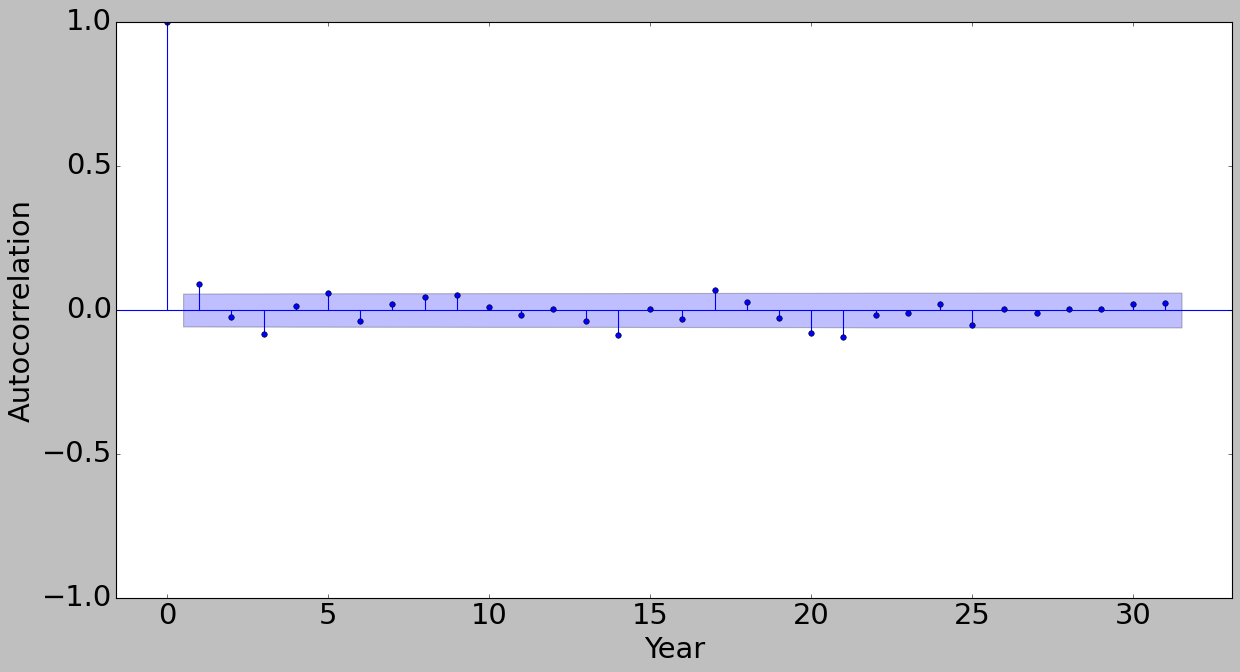

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams.update({'font.size': 26})
fig = plot_acf(mmkt.ret)
plt.xlabel("Year")
plt.ylabel("Autocorrelation")
plt.title("")
_ = fig.set_size_inches(18,9)

### Daily Returns

In [23]:
dmkt.head()

Date
1926-07-01    0.00109
1926-07-02    0.00459
1926-07-06    0.00179
1926-07-07    0.00099
1926-07-08    0.00219
Freq: D, dtype: float64

In [24]:
dmkt.index = dmkt.index.astype(str)
dmkt = dmkt.reset_index()
dmkt.columns = ['date','ret']
dmkt.head()

date      ret
0  1926-07-01  0.00109
1  1926-07-02  0.00459
2  1926-07-06  0.00179
3  1926-07-07  0.00099
4  1926-07-08  0.00219

In [27]:
# Plot time-series
fig = go.Figure()
trace= go.Scatter(x=dmkt.date, 
                  y=dmkt.ret,
                  hovertemplate='Date: %{x: %Y-%m-%d}<br>Return: %{y:.2f}%<extra></extra>')
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Return",
    yaxis_tickformat=".0%"
)
fig.show()

In [28]:
# Plot the distribution of annual returns
fig = go.Figure()
trace= go.Histogram(x=dmkt.ret, histnorm='percent',hovertemplate="<br>%{y:.2}% of years <br><extra></extra>")
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Daily Market Return",
    yaxis_title="Percent of Years",
    xaxis_tickformat=".0%"
)
fig.show()

In [29]:
from scipy.stats import norm
from scipy.stats import gaussian_kde as kde

# Density of actual returns
grid = np.linspace(np.min(dmkt.ret), np.max(dmkt.ret), 400)
empirical_density = kde(dmkt.ret)
trace1 = go.Scatter(x=grid,y=empirical_density(grid), mode="lines", name="actual")

# normal density with same mean and SD
m = dmkt.ret.mean()
s = dmkt.ret.std()
normal_density = norm.pdf(grid, loc=m, scale=s)
trace2= go.Scatter(x=grid, y=normal_density, mode='lines',name='normal')

fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Daily Market Return",
    yaxis_title="Density",
    xaxis_tickformat=".0%"
)
fig.show()

In [30]:
# Summary statistics
print(f'Mean(daily return):\t {dmkt.ret.mean(): ,.4f}')
print(f'SD(daily return):\t {dmkt.ret.std(): ,.4f}')
print(f'Skew(daily return):\t {dmkt.ret.skew(): ,.4f}')
print(f'Kurt(daily return):\t {dmkt.ret.kurt(): ,.4f}')  # excess kurtosis

Mean(daily return):	  0.0004
SD(daily return):	  0.0108
Skew(daily return):	 -0.1716
Kurt(daily return):	  16.3821


In [31]:
# Autocorrelation
dmkt['lag'] = dmkt['ret'].shift()
dmkt = dmkt.dropna().copy()
result = smf.ols("ret ~ lag", data=dmkt).fit()
dmkt['predict'] = result.params['Intercept'] + result.params['lag']*dmkt.lag
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     59.17
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           1.50e-14
Time:                        09:39:50   Log-Likelihood:                 80526.
No. Observations:               25879   AIC:                        -1.610e+05
Df Residuals:                   25877   BIC:                        -1.610e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004    6.7e-05      6.109      0.0

In [32]:
# scatter plot + regression line
fig = go.Figure()
trace1 = go.Scatter(
  x=dmkt.lag,
  y=dmkt.ret,
  text=dmkt.date,
  mode="markers",
  hovertemplate="%{text}<extra></extra>",
  showlegend=False,
  marker=dict(size=10)
)
fig.add_trace(trace1)

trace2 = go.Scatter(
  x=dmkt.lag,
  y=dmkt.predict,
  mode="lines",
  name="regression line",
)
fig.add_trace(trace2)
fig.update_layout(
    xaxis_title="Lagged Return",
    yaxis_title="Return",
    yaxis_title_font_size=24,
    xaxis_title_font_size=24,
    font_size=20,
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    width=1000,
    height=500,
)
fig.show()

In [33]:
dmkt[['ret','lag']].corr()

ret       lag
ret  1.000000  0.047764
lag  0.047764  1.000000

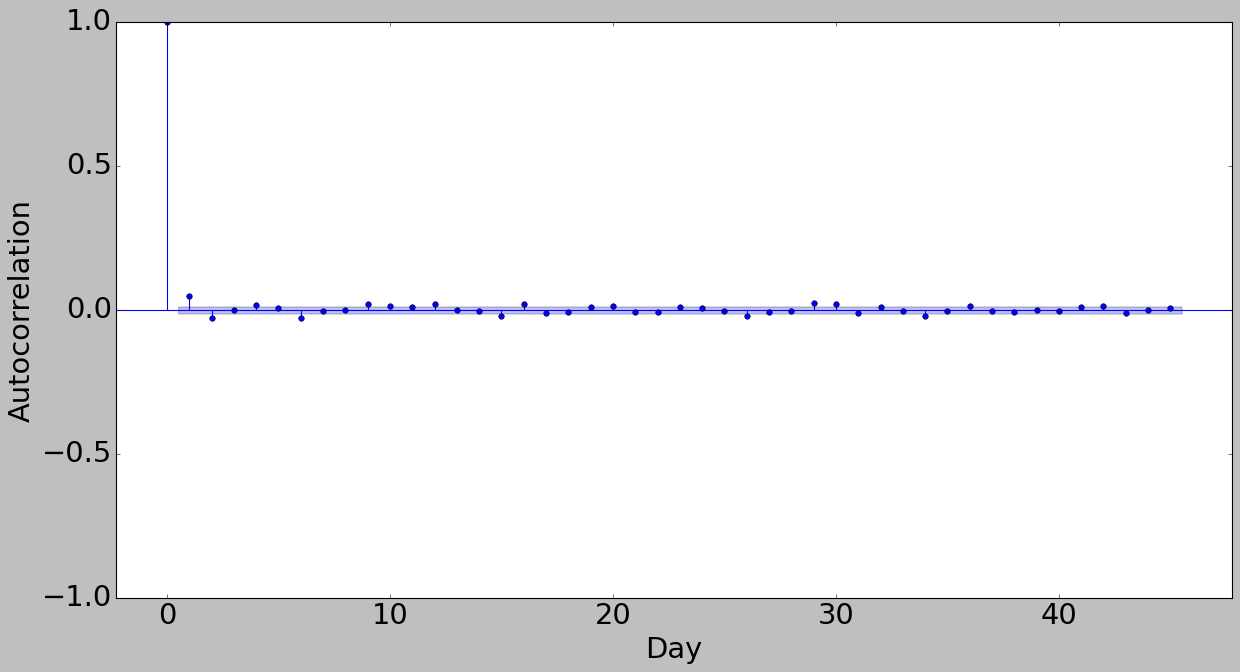

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams.update({'font.size': 26})
fig = plot_acf(dmkt.ret)
plt.xlabel("Day")
plt.ylabel("Autocorrelation")
plt.title("")
_ = fig.set_size_inches(18,9)

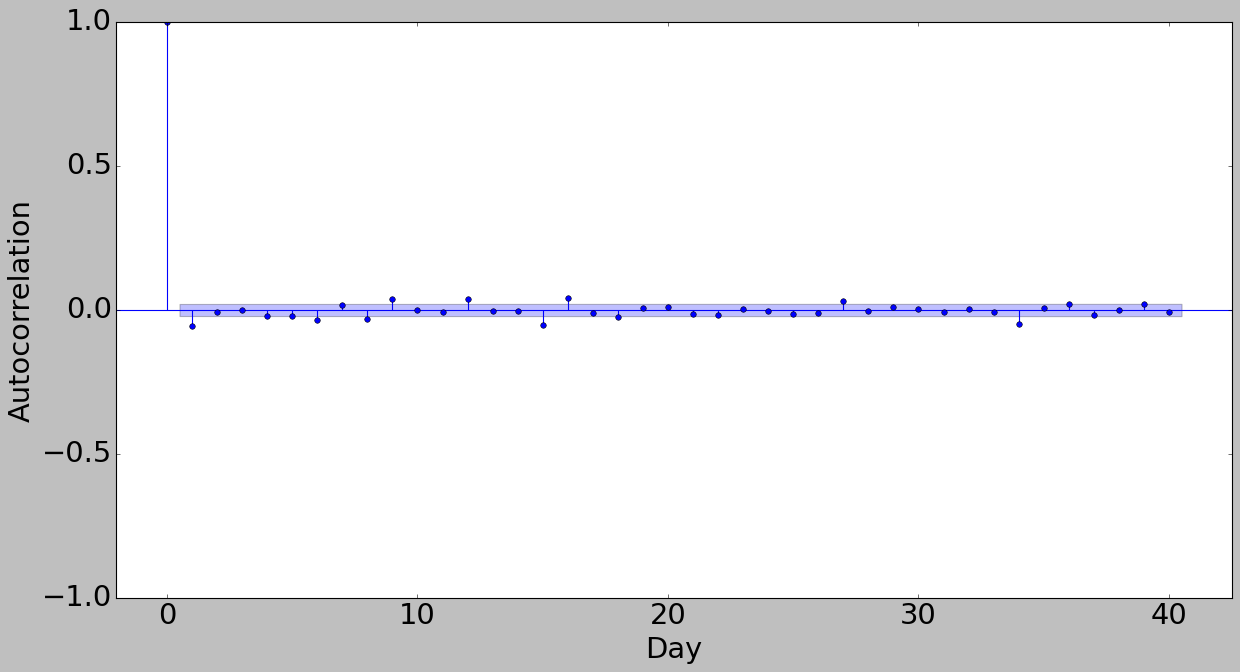

In [35]:
# Since 1990
row1990 = dmkt[dmkt.date=='1990-01-02'].index[0]
dmkt1990 = dmkt.iloc[row1990:].copy()

fig = plot_acf(dmkt1990.ret)
plt.xlabel("Day")
plt.ylabel("Autocorrelation")
plt.title("")
_ = fig.set_size_inches(18,9)

## Volatility

We can assess volatility in two ways:
1. Monthly series of SD(daily returns within each month)
2. Daily series of absolute value of returns

In [36]:
# quick aside on working with dates
dmkt['DATE']=pd.to_datetime(dmkt['date'])
dmkt.DATE.dt.year
dmkt.DATE.dt.month
dmkt.DATE.dt.month_name()
dmkt.DATE.dt.to_period('M')
dmkt['month'] = dmkt.DATE.dt.to_period('M')

### 1. Monthly series of SD(daily returns)

In [37]:
# standard deviation of returns each month
volatility = dmkt.groupby('month')['ret'].std()
volatility.index = volatility.index.astype(str)
volatility = volatility.reset_index()
volatility.columns=['month','sd_dret']
volatility

month   sd_dret
0     1926-07  0.004625
1     1926-08  0.005926
2     1926-09  0.004956
3     1926-10  0.008389
4     1926-11  0.003820
...       ...       ...
1176  2024-07  0.009147
1177  2024-08  0.012966
1178  2024-09  0.009118
1179  2024-10  0.007024
1180  2024-11  0.008506

[1181 rows x 2 columns]

In [38]:
# Plot monthly time-series
fig = go.Figure()
trace= go.Scatter(x=volatility.month, y=volatility.sd_dret)
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Volatility",
    yaxis_tickformat=".0%"
)
fig.show()

In [39]:
# Autocorrelation
volatility['lag'] = volatility['sd_dret'].shift()
volatility = volatility.dropna()
result = smf.ols("sd_dret ~ lag", data=volatility).fit()
volatility['predict'] = result.params['Intercept'] + result.params['lag']*volatility.lag
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                sd_dret   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     1077.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          2.43e-168
Time:                        09:40:03   Log-Likelihood:                 4743.9
No. Observations:                1180   AIC:                            -9484.
Df Residuals:                    1178   BIC:                            -9474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.000     12.146      0.0

C:\Users\kpc2\AppData\Local\Temp\ipykernel_23176\2109228529.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
# scatter plot + regression line
fig = go.Figure()
trace1 = go.Scatter(
  x=volatility.lag,
  y=volatility.sd_dret,
  text=volatility.month,
  mode="markers",
  hovertemplate="%{text}<extra></extra>",
  showlegend=False,
  marker=dict(size=10)
)
fig.add_trace(trace1)

trace2 = go.Scatter(
  x=volatility.lag,
  y=volatility.predict,
  mode="lines",
  name="regression line",
)
fig.add_trace(trace2)
fig.update_layout(
    xaxis_title="Lagged Volatility",
    yaxis_title="Volatility",
    yaxis_title_font_size=24,
    xaxis_title_font_size=24,
    font_size=20,
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    width=1000,
    height=500,
)
fig.show()

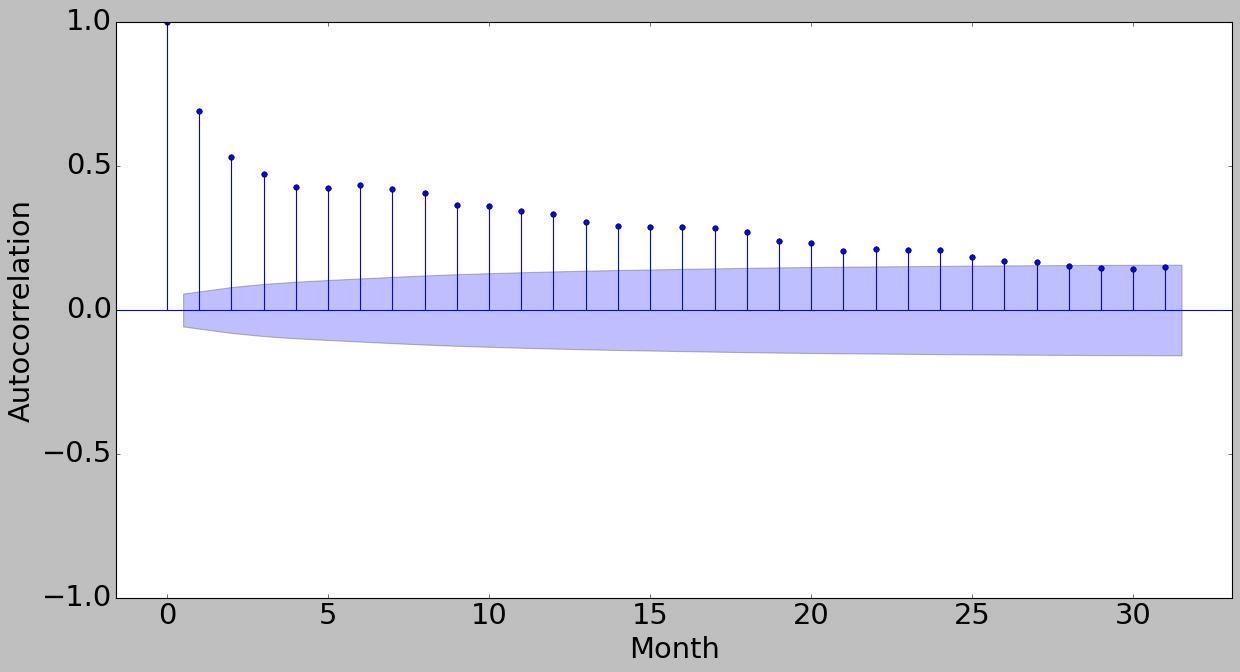

In [41]:
fig = plot_acf(volatility.sd_dret)
plt.xlabel("Month")
plt.ylabel("Autocorrelation")
plt.title("")
_ = fig.set_size_inches(18,9)

### 2. Daily series of abs(ret)

In [42]:
dmkt1990['abs_ret'] = np.abs(dmkt1990.ret)


In [43]:
# Plot daily time-series
fig = go.Figure()
trace= go.Scatter(x=dmkt1990.date, 
                  y=dmkt1990.abs_ret, 
                  hovertemplate='Date: %{x: %Y-%m-%d}<br>Abs Ret: %{y:.1%}%<extra></extra>')
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Volatility",
    yaxis_tickformat=".0%"
)
fig.show()

In [44]:
# Autocorrelation
dmkt1990['lag'] = dmkt1990['abs_ret'].shift()
dmkt1990 = dmkt1990.dropna()
result = smf.ols("abs_ret ~ lag", data=dmkt1990).fit()
dmkt1990['predict'] = result.params['Intercept'] + result.params['lag']*dmkt1990.lag
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_ret   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     702.3
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          6.08e-149
Time:                        09:40:07   Log-Likelihood:                 29839.
No. Observations:                8794   AIC:                        -5.967e+04
Df Residuals:                    8792   BIC:                        -5.966e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0056      0.000     47.670      0.0

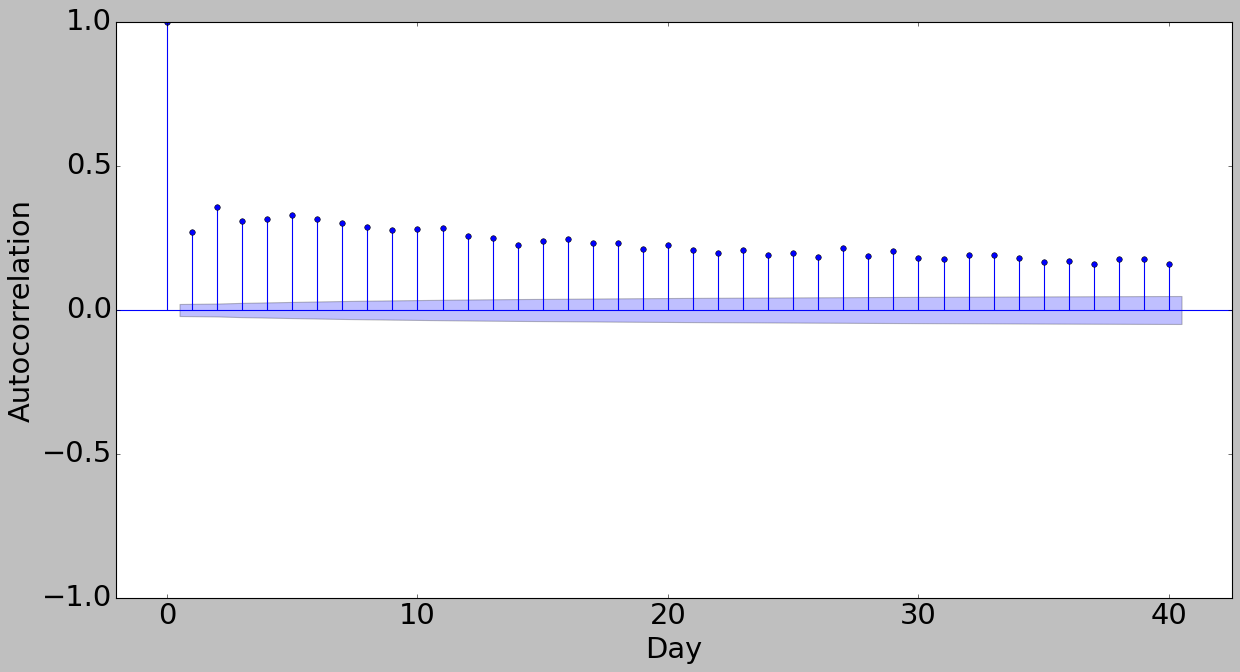

In [45]:
fig = plot_acf(dmkt1990.abs_ret)
plt.xlabel("Day")
plt.ylabel("Autocorrelation")
plt.title("")
_ = fig.set_size_inches(18,9)

In [46]:
# scatter plot + regression line
fig = go.Figure()
trace1 = go.Scatter(
  x=dmkt1990.lag,
  y=dmkt1990.abs_ret,
  text=dmkt.date,
  mode="markers",
  hovertemplate="%{text}<extra></extra>",
  showlegend=False,
  marker=dict(size=10)
)
fig.add_trace(trace1)

trace2 = go.Scatter(
  x=dmkt1990.lag,
  y=dmkt1990.predict,
  mode="lines",
  name="regression line",
)
fig.add_trace(trace2)
fig.update_layout(
    xaxis_title="Lagged Absolute Return",
    yaxis_title="Absolute Return",
    yaxis_title_font_size=24,
    xaxis_title_font_size=24,
    font_size=20,
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    width=1000,
    height=500,
)
fig.show()

## Saving with uncertain returns

In [50]:
from scipy.stats import norm
MEAN     = 0.125
SD       = 0.174
N_SAVING = 20
PMT      = 0.0
PV       = 1.0
NSIMS    = 1000

# function to capture ending balance
def endbal(mean, sd, n_saving, pmt):
    acct = pd.DataFrame(dtype=float,columns=['begbal','return','capgain','deposit','endbal'],index=np.arange(1,N_SAVING+1))
    acct.deposit = PMT
    acct['return'] = norm.rvs(loc=MEAN,scale=SD, size=N_SAVING)
    for t in acct.index:
        if t==1:
            acct.loc[t,'begbal'] = PV
        else:
            acct.loc[t,'begbal'] = acct.loc[t-1,'endbal']
        acct.loc[t,'capgain'] = acct.loc[t,'begbal']*acct.loc[t,'return']
        acct.loc[t,'endbal'] = acct.loc[t,'begbal'] + acct.loc[t,'capgain'] + acct.loc[t,'deposit']

    pd.options.display.float_format = '{:,.2f}'.format
    endbal = acct.loc[N_SAVING,'endbal']
    return endbal


df = pd.DataFrame(dtype=float,columns=['endbal'], index=np.arange(NSIMS))
for s in df.index:
    df.loc[s,'endbal']=endbal(MEAN,SD,N_SAVING,PMT)


In [51]:
df.describe()

endbal
count 1,000.00
mean     10.37
std       9.56
min       1.09
25%       5.05
50%       7.85
75%      12.68
max     149.54

In [52]:
# Plot the distribution of annual returns
fig = go.Figure()
trace= go.Histogram(x=df.endbal, histnorm='percent',hovertemplate="<br>%{y:.2}% of simulations <br><extra></extra>")
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.update_layout(
    xaxis_title="Ending Balance",
    yaxis_title="Percent of Years",
    xaxis_tickformat="$,.0f"
)
fig.show()